In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import california_housing

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

from tqdm import trange

import matplotlib.pyplot as plt

In [5]:
class MyDecisionTreeRegr:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0, max_features=None, random_state=None,
                 max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                 num_feats=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.num_feats = num_feats
        
        self.tree = dict()  # Номер узла: информация об узле.
        
        self.Leaf = True
        self.notLeaf = False

    def _search_split(self, X, y):
        sorted_idx = X.argsort(axis=0)
        sortedX = np.sort(X, axis=0)
        sortedY = y[sorted_idx]
        
        sumY = np.cumsum(sortedY, axis=0)
        sumY_2 = np.cumsum(sortedY**2, axis=0)
        revsumY = np.cumsum(sortedY[::-1], axis=0)[::-1]
        revsumY_2 = np.cumsum(sortedY[::-1]**2, axis=0)[::-1]
        
        # Вычисляю кумулятивно критерий для каждого разбиения, потом ищу максимум.
        length = np.array(range(1, X.shape[0]+1)).reshape(-1, 1)
        left_crit = sumY_2 - 2 * sumY**2 / length + sumY**2 / length**2
        right_crit = revsumY_2 - 2 * revsumY**2 / length[::-1] + revsumY**2 / length[::-1]**2
        
        crit = np.std(y)
        crit -= left_crit / y.shape[0]
        # Т.к. разделение в правую ветку идет со знаком <.
        crit[:-1] -= right_crit[1:] / y.shape[0]
        
        # Удалить неинформативные фичи.
        bad_idx = np.where(abs(np.max(sortedX, axis=0) - np.min(sortedX, axis=0)) < 0.001)[0]
        if bad_idx.shape[0] > 0:
            crit[:, bad_idx] = np.nan
        
        crit[np.isclose(sortedX, np.roll(sortedX, shift=-1, axis=0))] = np.nan

        # Для проверки, что не все NaN.
        try:
            _ = np.nanargmax(crit)
        except ValueError:
            return None, None, None, False

        crit[np.isnan(crit)] = float('-inf')
        # Отбираем лучшие отсечки по кадой фиче.
        best_splits = np.argmax(crit, axis=0).reshape(-1, 1)
        best_crits = np.zeros(best_splits.shape[0])
        non_inf_counter = 0  # Считаем сколько валидных отсечек.
        for i in range(best_splits.shape[0]):
            best_crits[i] = crit[best_splits[i], i]
            if best_crits[i] > float('-inf'):
                non_inf_counter += 1
        
        num_feat = self.num_feats
        if non_inf_counter < num_feat:
            num_feat = non_inf_counter
        # Отбираем лучшие фичи по своим лучшим отсечкам.
        best_feats = np.argpartition(-best_crits, num_feat, axis=None)[:num_feat]
        
        # Находим веса лучших фичей по размеру их критерия.
        feats_weight = np.zeros(best_feats.shape[0])
        sum_weight = np.sum(best_crits[best_feats])
        for i in range(best_feats.shape[0]):
            idx_left = np.where(X[:, best_feats[i]] <= best_splits[best_feats[i]], True, False)
            idx_right = ~idx_left
            sign = 1 if np.mean(sortedY[idx_left]) >= np.mean(sortedY[idx_right]) else -1
            feats_weight[i] = sign * best_crits[best_feats[i]] / float(sum_weight)
#             feats_weight[i] = sign

        feats_id = best_feats
        thrls_id = np.zeros(best_feats.shape[0])
        for i in range(best_feats.shape[0]):
            thrls_id[i] = sortedX[best_splits[feats_id[i]], feats_id[i]]
            
        return feats_id.astype(int), thrls_id, feats_weight, True
    
    def _make_partition(self, X, y, feature_id, threshold, weight, predict=False):
        # Смотрим какие фичи объектов <= своих отсечек, умножаем на свой вес.
        idx_left = np.sum(np.where(X[:, feature_id] <= threshold, 1, -1) * weight, axis=1) >= 0
        idx_right = ~idx_left

#         thrl = np.matmul(threshold.T, weight)
#         idx_left = np.matmul(X[:, feature_id], weight) >= thrl
#         idx_right = ~idx_left
    
        if predict is False:
            return X[idx_left], y[idx_left], X[idx_right], y[idx_right]
        else:
            return idx_left, idx_right
        
    def _fit_node(self, X, y, node_id, depth):
        # Если выполнен критерий остановки, создать листовую вершину.
        if (X.shape[0] < self.min_samples_split or depth == self.max_depth):
            self.tree[node_id] = [self.Leaf, np.mean(y)]
            return
        
        feature_id, threshold, weight, isOkay = self._search_split(X, y)
        
        # Значит скорее всего все фичи уже одинаковые в этом поддереве, двигаться некуда.
        if isOkay is False:
            self.tree[node_id] = [self.Leaf, np.mean(y)]
            return
        
        X_left, y_left, X_right, y_right = self._make_partition(X, y, feature_id,
                                                                threshold, weight)
        
        if (X_left.shape[0] < self.min_samples_leaf or
            X_right.shape[0] < self.min_samples_leaf):

            self.tree[node_id] = [self.Leaf, np.mean(y)]            
        else:
            self.tree[node_id] = [self.notLeaf, feature_id, threshold, weight]
            self._fit_node(X_left, y_left, 2*node_id+1, depth+1)
            self._fit_node(X_right, y_right, 2*node_id+2, depth+1)
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        self._fit_node(X, y, 0, 0)
        
    def _predict(self, X, node_id):
        node_info = self.tree[node_id]
        answer = np.zeros(X.shape[0])

        if node_info[0] is self.notLeaf:
            feature_id, threshold, weight = node_info[1], node_info[2], node_info[3]

            ids_left, ids_right = self._make_partition(X, None, feature_id,
                                                   threshold, weight, predict=True)
            answer[ids_left] = self._predict(X[ids_left], 2*node_id+1)
            answer[ids_right] = self._predict(X[ids_right], 2*node_id+2)
        else:
            answer = np.array([node_info[1]] * X.shape[0])
            
        return answer
            
        
    def predict(self, X):
        X = np.array(X)
        return self._predict(X, 0)

In [3]:
class constanta:
    def fit(self, X, y):
        self.result = np.mean(y)

    def predict(self, X):
        return self.result

In [6]:
class MyGradientBoostingRegr:
    def __init__(self, learning_rate=0.1, n_estimators=100, subsample=1.0,
                 min_samples_split=2, min_samples_leaf=1,
                 max_depth=3, alpha=0.9, uprage_trees=False,
                 base_estimator=MyDecisionTreeRegr, num_feats=None):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators + 1  # +1 для константы.
        self.subsample = subsample
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.alpha = alpha
        self.uprage_trees = uprage_trees
        self.base_estimator = base_estimator
        self.num_feats = num_feats
        
        self.estimators = []
        self.weights = []
        
        self.staged_error = []
        self.staged_validation_error = []
        
    def _calculate_weight(self, G_ij, X, h_next):
        y_pred = h_next.predict(X)
#         weights = G_ij / y_pred  # Было изначально так.
        weights = np.sum(y_pred * G_ij) / np.sum(y_pred**2)
        
        return np.mean(weights)
        
    def fit(self, X, y, X_test=None, y_test=None, validation=False):
        X = np.array(X)
        y = np.array(y)
        
        h_curr = constanta()
#         h_curr = MyDecisionTreeRegr(max_depth=3)
        h_curr.fit(X, y)
        w_curr = 1.0 * 1  #self.learning_rate
        self.estimators.append(h_curr)
        self.weights.append(w_curr)
        
        G_ij = y
        G_ij_test = y_test
        
        for i in range(1, self.n_estimators):
#             if self.uprage_trees:
#                 if i % 100 == 0:
#                     self.max_depth += 1
            
            y_pred = h_curr.predict(X) * w_curr
            G_ij = G_ij - y_pred
            
            self.staged_error.append(np.mean(G_ij**2))
            
            if validation is True:
                y_pred_test = h_curr.predict(X_test) * w_curr
                G_ij_test = G_ij_test - y_pred_test
                self.staged_validation_error.append(np.mean(G_ij_test**2))
            
#             h_next = MyDecisionTreeRegr(max_depth=self.max_depth)
            if self.num_feats is not None:
                h_next = self.base_estimator(max_depth=self.max_depth, num_feats=self.num_feats)
            else:
                h_next = self.base_estimator(max_depth=self.max_depth)
            h_next.fit(X, G_ij)
            
            w_next = self._calculate_weight(G_ij, X, h_next) * self.learning_rate
            
            self.estimators.append(h_next)
            self.weights.append(w_next)
            
            h_curr = h_next
            w_curr = w_next
            
            

    def predict(self, X):
        answer = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            answer += self.weights[i] * self.estimators[i].predict(X)
        return answer

In [ ]:
my_gbr = MyGradientBoostingRegr(n_estimators=700, base_estimator=DecisionTreeRegressor)
my_gbr.fit(X_train, y_train, X_test, y_test, True)

In [10]:
gbr = GradientBoostingRegressor(n_estimators=700)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=700,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
gbr_staged_pred = [np.mean((i-y_test)**2) for i in gbr.staged_predict(X_test)]

Text(0, 0.5, 'MSE')

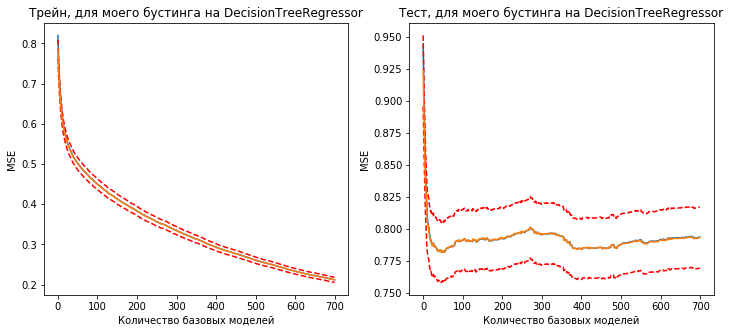

In [24]:
t = [i for i in range(len(my_gbr.staged_error))]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, my_gbr.staged_error)
plt.plot(t, np.array(gbr.train_score_[:])*1.03, c='r', linestyle='--')
plt.plot(t, np.array(gbr.train_score_[:])*0.97, c='r', linestyle='--')
plt.plot(t, gbr.train_score_[:])
plt.xlabel("Количество базовых моделей")
plt.title("Трейн, для моего бустинга на DecisionTreeRegressor")
plt.ylabel("MSE")

plt.subplot(1, 2, 2)
plt.plot(t, my_gbr.staged_validation_error)
plt.plot(t, np.array(gbr_staged_pred[:])*1.03, c='r', linestyle='--')
plt.plot(t, np.array(gbr_staged_pred[:])*0.97, c='r', linestyle='--')
plt.plot(t, gbr_staged_pred[:])
plt.xlabel("Количество базовых моделей")
plt.title("Тест, для моего бустинга на DecisionTreeRegressor")
plt.ylabel("MSE")

In [9]:
my_gbr_lin3 = MyGradientBoostingRegr(n_estimators=500, num_feats=3)
my_gbr_lin3.fit(X_train, y_train, X_test, y_test, True)

/home/ivan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ivan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


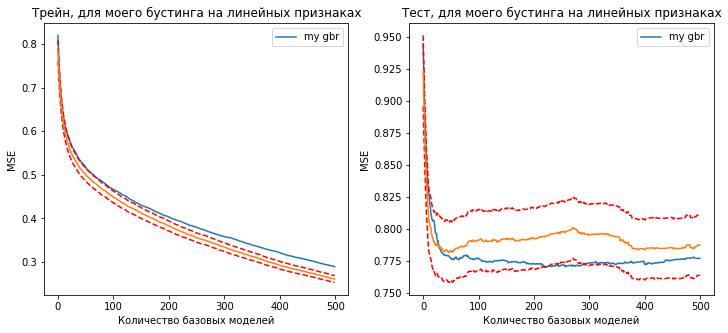

In [16]:
t = [i for i in range(len(my_gbr_lin3.staged_error[:500]))]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, my_gbr_lin3.staged_error, label='my gbr')
plt.plot(t, np.array(gbr.train_score_[:500])*1.03, c='r', linestyle='--')
plt.plot(t, np.array(gbr.train_score_[:500])*0.97, c='r', linestyle='--')
plt.plot(t, gbr.train_score_[:500])
plt.xlabel("Количество базовых моделей")
plt.title("Трейн, для моего бустинга на линейных признаках")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, my_gbr_lin3.staged_validation_error, label='my gbr')
plt.plot(t, np.array(gbr_staged_pred[:500])*1.03, c='r', linestyle='--')
plt.plot(t, np.array(gbr_staged_pred[:500])*0.97, c='r', linestyle='--')
plt.plot(t, gbr_staged_pred[:500])
plt.xlabel("Количество базовых моделей")
plt.title("Тест, для моего бустинга на линейных признаках")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [8]:
X_train = []
y_train = []
with open('Regression dataset/reg.train.txt', 'r') as file:

    for line in file:
        try:
            line = line.rstrip()
            buf = line.split()
            y = buf[0]
            y_train.append(float(y))

            x = np.array([-9.0]*245)
            for elem in buf[1:-1]:
                id, feat = elem.split(':')
                x[int(id)-1] = float(feat)
            X_train.append(x)
        except:
            print(line)
    
    line = file.readline()
    
X_train = np.array(X_train)
y_train = np.array(y_train)


X_test = []
y_test = []
with open('Regression dataset/reg.test.txt', 'r') as file:

    for line in file:
        try:
            line = line.rstrip()
            buf = line.split()
            y = buf[0]
            y_test.append(float(y))

            x = np.array([-9.0]*245)
            for elem in buf[1:-1]:
                id, feat = elem.split(':')
                x[int(id)-1] = float(feat)
            X_test.append(x)
        except:
            print(line)
    
    line = file.readline()
        
    
    
X_test = np.array(X_test)
y_test = np.array(y_test)